# Constructing Morphological Networks from Overture Maps

In this notebook, we'll walk through the following workflow:

1. **Data Preparation**: Loading and processing street segments and building data from Overture Maps
2. **Space Division**: Creating morphological tessellations to represent private spaces
3. **Network Creation**: Generating different types of morphological networks:
   - Private-to-private connections (between adjacent private spaces)
   - Public-to-public connections (between street segments)
   - Private-to-public connections (between private spaces and streets)
4. **Graph Conversion**: Converting spatial networks to graph representations using PyTorch Geometric
5. **Visualization**: Exploring different ways to visualize the morphological networks

These graph representations enable various analyses of urban form, including connectivity studies, accessibility measures, and graph-based machine learning for urban analytics.

## 1. Setup and Environment

In [1]:
import numpy as np
from shapely import Point
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
import city2graph
import folium

# Configure matplotlib for better visualizations
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams['figure.dpi'] = 100
plt.style.use('ggplot')

## 2. Data Loading and Preparation

We'll work with data from Liverpool, UK, including building footprints and road network segments. These data are stored as GeoJSON files. `area` accepts either bbox or Polygon in WGS84.

In [2]:
bbox = [-3.090173,53.355487,-2.917138,53.465587] # Liverpool city centre
city2graph.load_overture_data(area=bbox,
                              types=["segment", "building", "connector"],
                              output_dir=".",
                              prefix="liverpool_",
                              save_to_file=True,
                              return_data=False)

{}

In [2]:
# Load GeoJSON files
buildings_gdf = gpd.read_file("liverpool_building.geojson")
segments_gdf = gpd.read_file("liverpool_segment.geojson")
connectors_gdf = gpd.read_file("liverpool_connector.geojson")

# Convert to British National Grid (EPSG:27700)
buildings_gdf = buildings_gdf.to_crs(epsg=27700)
segments_gdf = segments_gdf.to_crs(epsg=27700)
connectors_gdf = connectors_gdf.to_crs(epsg=27700)

print(f"Loaded {len(buildings_gdf)} buildings, {len(segments_gdf)} segments, and {len(connectors_gdf)} connectors")

Loaded 132972 buildings, 37474 segments, and 47367 connectors


## 3. Street Network Processing

`city2graph` offers functions that can process and clean up the original segments from Overture Maps. Eventually, `barrier_geometry` stores the ones not considered as tunnels and/or bridges.

In [3]:
# Filter road segments and process them to handle tunnels
segments_gdf = segments_gdf[segments_gdf["subtype"] == "road"].copy()

# Identify tunnels and set their geometry to None
segments_gdf["barrier_mask"] = segments_gdf["level_rules"].apply(city2graph.identify_barrier_mask)

# Split segments by connectors
segments_gdf = city2graph.split_segments_by_connectors(segments_gdf, connectors_gdf)

# Filter road segments and process them to handle tunnels
segments_gdf = city2graph.adjust_segment_connectors(segments_gdf, threshold=1.0)

# Calculate the length of each segment
segments_gdf["length"] = segments_gdf.geometry.length

# Create barrier_geometry column by processing each segment (excluding tunnels)
segments_gdf["barrier_geometry"] = city2graph.get_barrier_geometry(segments_gdf)

## 4. Create Morphological Network
Based on the preprocessed segments and buildings, **a morphological network** is created by the following process:

<div align="center">
    <img src="../_static/morph_net_process.png" alt="City2Graph Logo" width="1000"/>
</div>

Morphological network is a heterogenous graph where all the spaces in cities are holistically represented as nodes. 

In this representation, the topological connections between public and private spaces can be captured. Unlike street network and contiguity matrix of built environment, morphological network can accomodate any of the charactors for urban forms and functions, such as POIs, land-use, street types, and etc. It will be a foundation for spatially-explicit GeoAI by graph representation learning, keeping the characters as node attributes.

There are three types of connections as edges: public-to-public, private-to-private, and private-to-public. Public-to-public connections are dual representation of street networks. Private-to-private shows the contiguities between enclosed tessellations as plot systems. Private-to-public can identify the adjacency between public and private spaces.

`city2graph.morphological_network` can process the creation of morphological network as a dictionary of `gpd.GeoDataFrame` consisting of `['tessellations', 'segments', 'buildings', 'private_to_private', 'public_to_public', 'private_to_public']`. Post-processing, such as mapping POIs to private spaces, can be done accordingly.

In [5]:
center_point = gpd.GeoSeries([Point((-2.9879004, 53.4062724))], crs='EPSG:4326').to_crs(epsg=27700)

morphological_network = city2graph.morphological_network(
    buildings_gdf=buildings_gdf,
    segments_gdf=segments_gdf,
    center_point=center_point,
    distance=500,
    public_geom_col='barrier_geometry',
    contiguity="queen"
    )

/opt/anaconda3/envs/city2graph_env/lib/python3.12/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 2, 4.
  W.__init__(self, neighbors, ids=ids, **kw)


In [6]:
morphological_network.keys()

dict_keys(['tessellations', 'segments', 'buildings', 'private_to_private', 'public_to_public', 'private_to_public'])

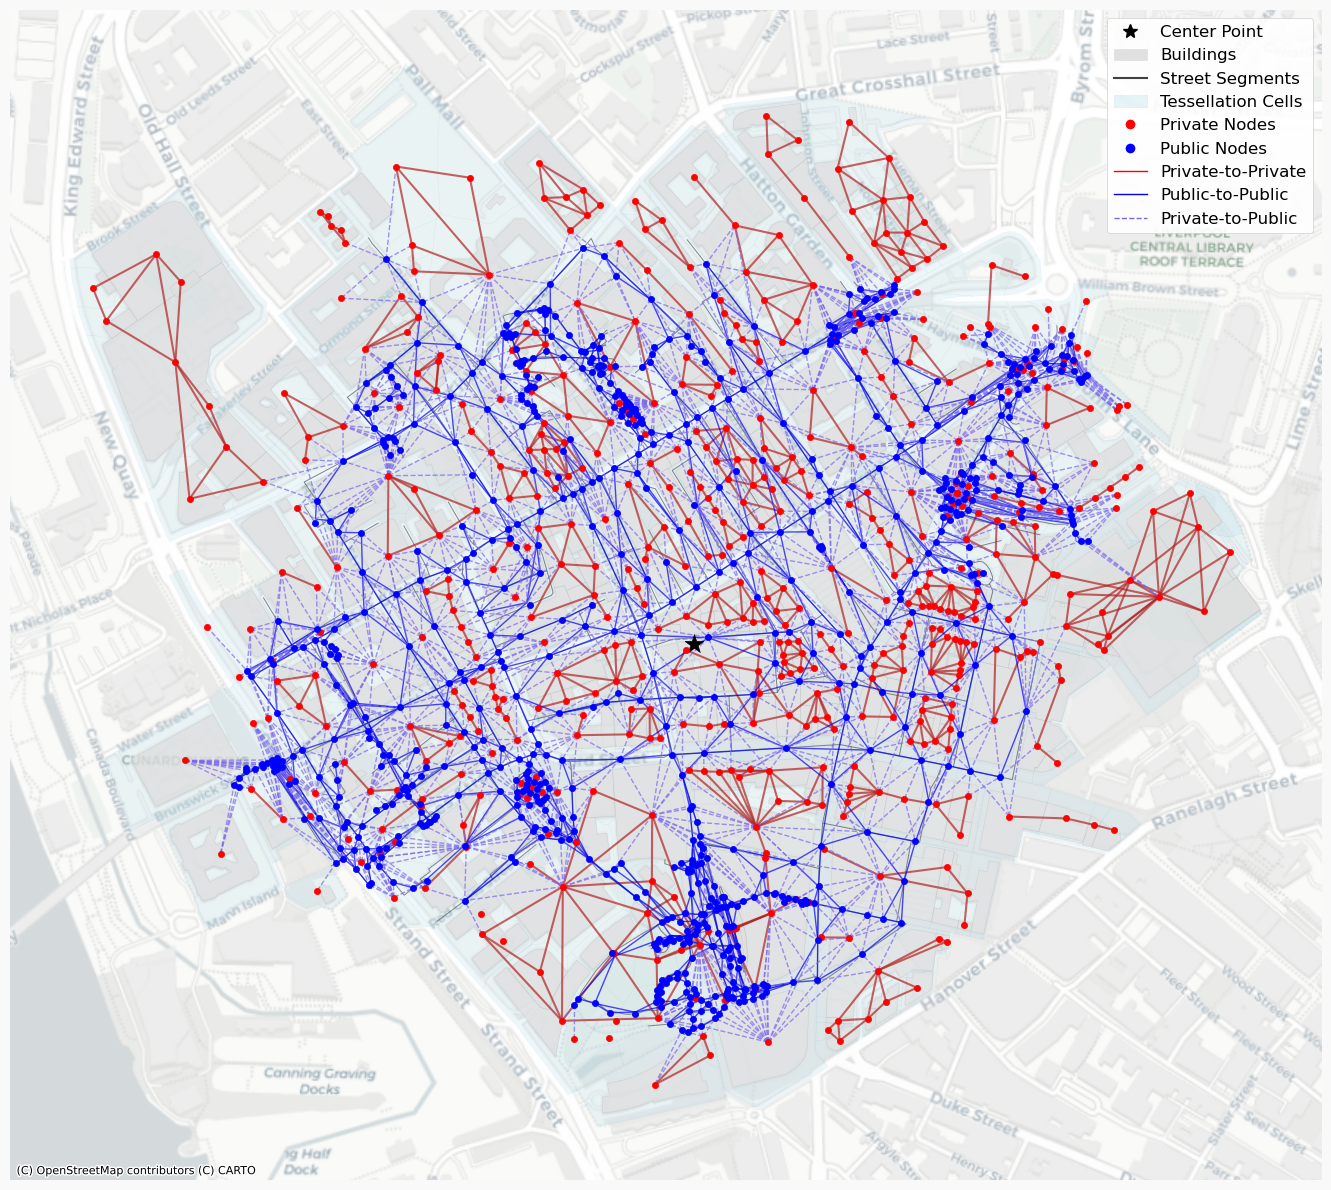

In [7]:
# Set up the figure with a nice size and background
fig, ax = plt.subplots(figsize=(14, 12), facecolor='#f9f9f9')

# Plot central point
ax.scatter(center_point.x, center_point.y, color='black', marker='*', s=200, zorder=5, label='Center Point')

# Plot background elements with improved styling
morphological_network["tessellations"].plot(ax=ax, color='#ADD8E6', edgecolor='#87CEEB', linewidth=0.2, alpha=0.2)
morphological_network["buildings"].plot(ax=ax, color='#e0e0e0', edgecolor='#c0c0c0', linewidth=0.3, alpha=0.7)
morphological_network["segments"].plot(ax=ax, color='#404040', linewidth=0.7, alpha=0.6)

# Plot the three network types with distinctive styles
morphological_network["private_to_private"].plot(ax=ax, color='#B22222', linewidth=1.5, alpha=0.7)
morphological_network["public_to_public"].plot(ax=ax, color='#0000FF', linewidth=1.0, alpha=0.7)
morphological_network["private_to_public"].plot(ax=ax, color='#7B68EE', linewidth=1.0, alpha=0.7, linestyle='--')

# Add nodes: private nodes from tessellation centroids (red) and public nodes as midpoints of segments (blue)
private_nodes = morphological_network["tessellations"].centroid
ax.scatter(private_nodes.x, private_nodes.y, color='red', s=20, zorder=10, label='Private Spaces')

public_nodes = morphological_network["segments"].geometry.apply(lambda geom: geom.interpolate(0.5, normalized=True))
ax.scatter(public_nodes.x, public_nodes.y, color='blue', s=20, zorder=10, label='Public Spaces')

# Create a legend with clear labels
legend_elements = [
    plt.Line2D([0], [0], color='black', marker='*', linestyle='None', markersize=10, label='Center Point'),
    plt.Rectangle((0, 0), 1, 1, color='#e0e0e0', label='Buildings'),
    plt.Line2D([0], [0], color='#404040', lw=1.5, label='Street Segments'),
    plt.Rectangle((0, 0), 1, 1, color='#ADD8E6', alpha=0.3, label='Tessellation Cells'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, linestyle='None', label='Private Nodes'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, linestyle='None', label='Public Nodes'),
    plt.Line2D([0], [0], color='red', lw=1, label='Private-to-Private'),
    plt.Line2D([0], [0], color='blue', lw=1, label='Public-to-Public'),
    plt.Line2D([0], [0], color='#7B68EE', lw=1, linestyle='--', label='Private-to-Public'),
]

# Position the legend inside the plot (upper right)
ax.legend(handles=legend_elements, loc='upper right', 
          frameon=True, facecolor='white', framealpha=0.9, fontsize=12)

# Add title and remove axes
ax.set_axis_off()

# Add basemap from Stamen Terrain below everything else
cx.add_basemap(ax, crs='EPSG:27700', source=cx.providers.CartoDB.Positron, alpha=1)

plt.tight_layout()
plt.show()

### Interactive Visualization with Folium

In [ ]:
def add_gdf_to_map(gdf, map_obj, style_function, tooltip=None, layer_name='Layer'):
    # Create a copy and drop any problematic columns (non-JSON serializable)
    gdf_copy = gdf.copy()
    for col in ['barrier_geometry', '_original_geometry']:
        if col in gdf_copy.columns:
            gdf_copy = gdf_copy.drop(columns=[col])
            
    # Add the GeoJSON layer
    folium.GeoJson(
        gdf_copy.to_crs(epsg=4326),
        name=layer_name,
        style_function=style_function,
        tooltip=tooltip
    ).add_to(map_obj)

def add_endpoints_from_lines(gdf, map_obj, color):
    # For each linestring, mark its start and end with CircleMarkers
    for geom in gdf.to_crs(epsg=4326).geometry:
        coords = list(geom.coords)
        for coord in (coords[0], coords[-1]):
            folium.CircleMarker(
                location=[coord[1], coord[0]],
                radius=3,
                color=color,
                fill=True,
                fill_color=color
            ).add_to(map_obj)

# Convert the study area center to EPSG:4326 once
center_point_4326 = center_point.to_crs(epsg=4326)
center_lat = center_point_4326.geometry.iloc[0].y
center_lon = center_point_4326.geometry.iloc[0].x

# Create the base map
m = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=15,
    tiles='https://{s}.basemaps.cartocdn.com/light_all/{z}/{x}/{y}{r}.png',
    attr='&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors &copy; <a href="https://carto.com/attributions">CARTO</a>'
)

# Configuration for layer additions from morphological_network
layers_config = [
    {
        'data': morphological_network["buildings"],
        'name': 'Buildings',
        'style': lambda x: {'fillColor': 'black', 'color': None, 'weight': 0, 'fillOpacity': 0.1}
    },
    {
        'data': morphological_network["segments"],
        'name': 'Street Segments',
        'style': lambda x: {'color': 'blue', 'weight': 2, 'opacity': 1},
        'tooltip': folium.GeoJsonTooltip(
            fields=['id', 'class', 'subtype', 'length'],
            aliases=['ID:', 'Road Class:', 'Subtype:', 'Length (m):'],
            localize=True,
            sticky=False,
            labels=True
        )
    },
    {
        'data': morphological_network["tessellations"],
        'name': 'Tessellation',
        'style': lambda x: {'fillColor': '#ff0000', 'color': '#ff0000', 'weight': 1, 'fillOpacity': 0},
        'tooltip': folium.GeoJsonTooltip(
            fields=['tess_id', 'enclosure_index'],
            aliases=['Tessellation ID:', 'Enclosure Index:'],
            localize=True,
            sticky=False,
            labels=True
        )
    },
    {
        'data': morphological_network["private_to_private"],
        'name': 'Private-to-Private',
        'style': lambda x: {'color': 'red', 'weight': 2, 'opacity': 1, 'dashArray': '5,5'},
        'tooltip': folium.GeoJsonTooltip(
            fields=['from_private_id', 'to_private_id'],
            aliases=['From:', 'To:'],
            localize=True,
            sticky=False,
            labels=True
        )
    },
    {
        'data': morphological_network["public_to_public"],
        'name': 'Public-to-Public',
        'style': lambda x: {'color': '#0000FF', 'weight': 2, 'opacity': 1, 'dashArray': '5,5'},
        'tooltip': folium.GeoJsonTooltip(
            fields=['from_public_id', 'to_public_id'],
            aliases=['From:', 'To:'],
            localize=True,
            sticky=False,
            labels=True
        )
    },
    {
        'data': morphological_network["private_to_public"],
        'name': 'Private-to-Public',
        'style': lambda x: {'color': '#7B68EE', 'weight': 2, 'opacity': 1, 'dashArray': '5,5'},
        'tooltip': folium.GeoJsonTooltip(
            fields=['private_id', 'public_id'],
            aliases=['Private Node:', 'Public Node:'],
            localize=True,
            sticky=False,
            labels=True
        )
    }
]

for layer in layers_config:
    add_gdf_to_map(layer['data'], m, layer['style'], tooltip=layer.get('tooltip'), layer_name=layer['name'])

# Add endpoints for connection layers
add_endpoints_from_lines(morphological_network["public_to_public"], m, color='#0000FF')
add_endpoints_from_lines(morphological_network["private_to_private"], m, color='red')

# Add layer control and display the map
folium.LayerControl().add_to(m)
m

## 5. Convert to Graph Representations

Now we'll convert our morphological networks to graph representations using PyTorch Geometric for graph representation learning. As dependencies, `torch` and `torch_geometric` have to be installed in advance.

In [9]:
# Import PyTorch and PyTorch Geometric
import torch
try:
    import torch_geometric
    HAS_TORCH_GEOMETRIC = True
    print("PyTorch Geometric successfully imported")
    print(f"PyTorch version: {torch.__version__}")
    print(f"PyTorch Geometric version: {torch_geometric.__version__}")
except ImportError:
    print("PyTorch Geometric not installed. Graph functionality will be limited.")
    HAS_TORCH_GEOMETRIC = False

PyTorch Geometric successfully imported
PyTorch version: 2.4.1
PyTorch Geometric version: 2.6.1


### 5.1 Create a Homogeneous Graph

First, let's create a homogeneous graph of private spaces (tessellation cells) with their connections. `homogenous_graph` generates `torch_geometric.data.Data` with a single type of edges.

In [4]:
# Import liverpool_place.geojson
liverpool_place_gdf = gpd.read_file("liverpool_place.geojson")
# Convert to EPSG:27700
liverpool_place_gdf = liverpool_place_gdf.to_crs(epsg=27700)

In [32]:
# Import liverpool_land.geojson
liverpool_land_gdf = gpd.read_file("liverpool_land.geojson")
# Convert to EPSG:27700
liverpool_land_gdf = liverpool_land_gdf.to_crs(epsg=27700)

# Import liverpool_land_use.geojson
liverpool_land_use_gdf = gpd.read_file("liverpool_land_use.geojson")
# Convert to EPSG:27700
liverpool_land_use_gdf = liverpool_land_use_gdf.to_crs(epsg=27700)

# Import liverpool_land_cover.geojson
liverpool_land_cover_gdf = gpd.read_file("liverpool_land_cover.geojson")
# Convert to EPSG:27700
liverpool_land_cover_gdf = liverpool_land_cover_gdf.to_crs(epsg=27700)

In [35]:
liverpool_land_cover_gdf

,id,version,sources,cartography,subtype,geometry
0,08b19510523b3fff0005d340df8ecc42,0,"[ { ""property"": """", ""dataset"": ""ESA WorldCover...","{ ""min_zoom"": 8, ""max_zoom"": 15, ""sort_key"": 1 }",urban,"POLYGON ((332568.319 382014.093, 332575.571 38..."
1,08b1951073632fff0005ddeccb5afd27,0,"[ { ""property"": """", ""dataset"": ""ESA WorldCover...","{ ""min_zoom"": 8, ""max_zoom"": 15, ""sort_key"": 3 }",barren,"POLYGON ((333631.006 390749.979, 333657.644 39..."
2,08b19510737a4fff0005dc226ef0157a,0,"[ { ""property"": """", ""dataset"": ""ESA WorldCover...","{ ""min_zoom"": 8, ""max_zoom"": 15, ""sort_key"": 3 }",barren,"POLYGON ((333621.657 390963.912, 333639.539 39..."
3,08b195107345cfff0005d580e1191be0,0,"[ { ""property"": """", ""dataset"": ""ESA WorldCover...","{ ""min_zoom"": 8, ""max_zoom"": 15, ""sort_key"": 3 }",barren,"POLYGON ((333570.259 391094.45, 333631.448 391..."
4,08b1951073433fff0005d9b17dabe047,0,"[ { ""property"": """", ""dataset"": ""ESA WorldCover...","{ ""min_zoom"": 8, ""max_zoom"": 15, ""sort_key"": 3 }",barren,"POLYGON ((333369.945 391358.566, 333392.094 39..."
5,08b1951055a2cfff0005d837237cfdf4,0,"[ { ""property"": """", ""dataset"": ""ESA WorldCover...","{ ""min_zoom"": 8, ""max_zoom"": 15, ""sort_key"": 2 }",forest,"POLYGON ((334505.586 388910.68, 334557.394 388..."
6,08b1951071454fff0005ddccf5de1115,0,"[ { ""property"": """", ""dataset"": ""ESA WorldCover...","{ ""min_zoom"": 8, ""max_zoom"": 15, ""sort_key"": 2 }",forest,"POLYGON ((335849.645 391136.24, 335968.773 391..."
7,08b19510710a3fff0005d204ec30fdcc,0,"[ { ""property"": """", ""dataset"": ""ESA WorldCover...","{ ""min_zoom"": 0, ""max_zoom"": 7, ""sort_key"": 1 }",urban,"POLYGON ((339727.216 379993.998, 342121.156 37..."
8,08b1951062a42fff0005d05c64a5511a,0,"[ { ""property"": """", ""dataset"": ""ESA WorldCover...","{ ""min_zoom"": 8, ""max_zoom"": 15, ""sort_key"": 1 }",urban,"POLYGON ((342361.106 382068.914, 342897.882 38..."
9,08b195100d9adfff0005dcaeaec9ae14,0,"[ { ""property"": """", ""dataset"": ""ESA WorldCover...","{ ""min_zoom"": 8, ""max_zoom"": 15, ""sort_key"": 1 }",urban,"POLYGON ((333607.626 390445.575, 333625.661 39..."


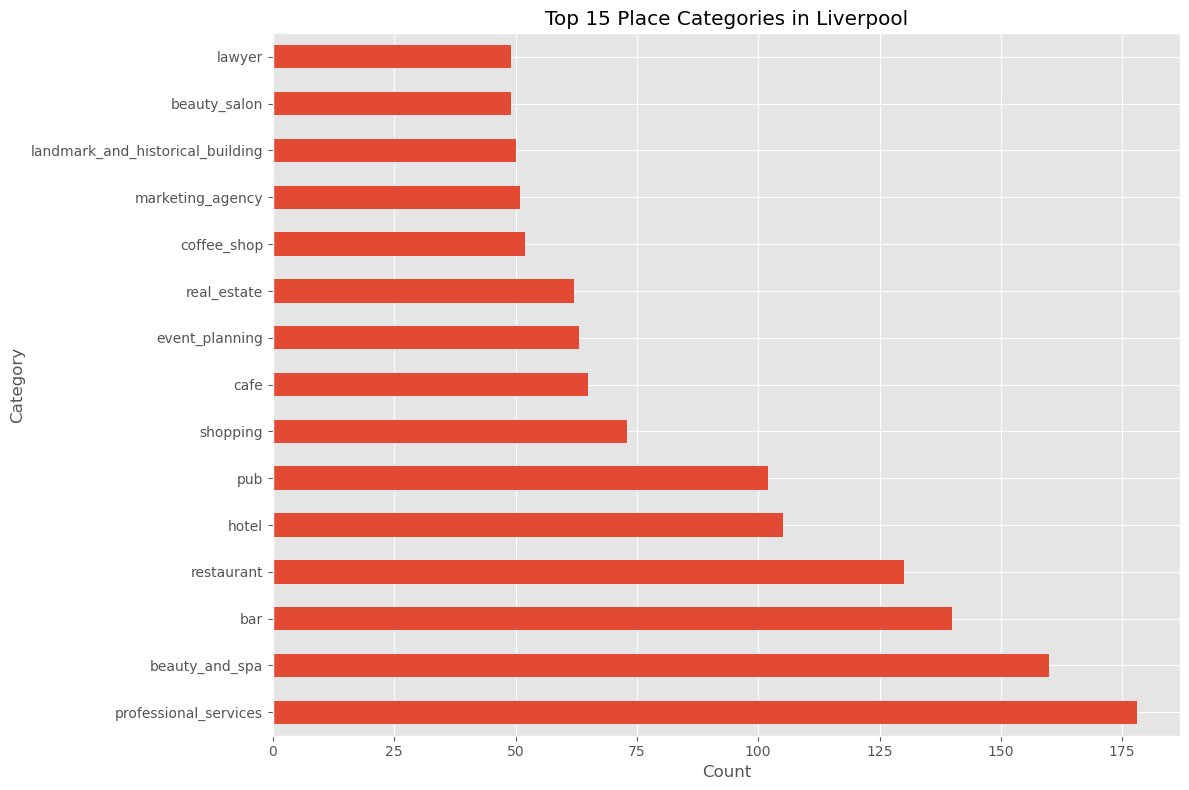

In [11]:
import json

# Function to parse the categories JSON string
def extract_categories(cat_str):
    if cat_str is None:
        return {"primary": None, "alternate": []}
    
    # Try parsing the JSON
    try:
        return json.loads(cat_str.replace("'", '"')) if isinstance(cat_str, str) else cat_str
    except:
        return {"primary": None, "alternate": []}

# Apply to the dataframe
liverpool_place_gdf['categories_parsed'] = liverpool_place_gdf['categories'].apply(extract_categories)

# Extract primary category and alternate categories to separate columns
liverpool_place_gdf['primary_category'] = liverpool_place_gdf['categories_parsed'].apply(
    lambda x: x.get('primary') if x else None
)
liverpool_place_gdf['alternate_categories'] = liverpool_place_gdf['categories_parsed'].apply(
    lambda x: x.get('alternate', []) if x else []
)

# Display the distribution of primary categories
primary_category_counts = liverpool_place_gdf['primary_category'].value_counts()

# Create a plot of the category distribution
plt.figure(figsize=(12, 8))
primary_category_counts.head(15).plot(kind='barh')
plt.title('Top 15 Place Categories in Liverpool')
plt.xlabel('Count')
plt.ylabel('Category')
plt.tight_layout()
plt.show()

In [12]:
liverpool_place_gdf

,id,version,sources,names,categories,confidence,brand,addresses,geometry,categories_parsed,primary_category,alternate_categories
0,08f195105513493003f580dfe6a29c9b,0,"[ { ""property"": """", ""dataset"": ""meta"", ""record...","{ ""primary"": ""Ливърпул"", ""common"": null, ""rule...","{ ""primary"": ""museum"", ""alternate"": [ ""history...",0.490748,None,"[ { ""freeform"": null, ""locality"": ""Liverpool"",...",POINT (333607.889 389705.767),"{'primary': 'museum', 'alternate': ['history_m...",museum,"[history_museum, community_museum]"
1,08f1951055b8d1b403e602c0253d829a,0,"[ { ""property"": """", ""dataset"": ""meta"", ""record...","{ ""primary"": ""The Docks Tattoo Expo"", ""common""...","{ ""primary"": ""topic_concert_venue"", ""alternate...",0.308564,None,"[ { ""freeform"": ""Kings docks"", ""locality"": ""Li...",POINT (334247.995 389163.127),"{'primary': 'topic_concert_venue', 'alternate'...",topic_concert_venue,None
2,08f1951055baba1a035648e7d0f1ba8e,0,"[ { ""property"": """", ""dataset"": ""meta"", ""record...","{ ""primary"": ""Indoor Funfair - Liverpool Exhib...",None,0.251852,None,"[ { ""freeform"": null, ""locality"": ""Liverpool"",...",POINT (334278.724 389175.275),"{'primary': None, 'alternate': []}",None,[]
3,08f1951055bab34903a9c78a4e74ed46,0,"[ { ""property"": """", ""dataset"": ""meta"", ""record...","{ ""primary"": ""Arena & Conference centre, Liver...","{ ""primary"": ""cinema"", ""alternate"": [ ""arts_an...",0.251852,None,"[ { ""freeform"": null, ""locality"": ""Liverpool"",...",POINT (334283.664 389177.543),"{'primary': 'cinema', 'alternate': ['arts_and_...",cinema,[arts_and_entertainment]
4,08f1951055baa883032110cf8a679da4,0,"[ { ""property"": """", ""dataset"": ""msft"", ""record...","{ ""primary"": ""Pullman Liverpool Hotel"", ""commo...","{ ""primary"": ""resort"", ""alternate"": [ ""hotel"" ] }",0.908486,None,"[ { ""freeform"": ""Kings Dock, Monarchs Quay"", ""...",POINT (334234.858 389241.588),"{'primary': 'resort', 'alternate': ['hotel']}",resort,[hotel]
...,...,...,...,...,...,...,...,...,...,...,...,...
5712,08f1951071791559031a4352cb5578a2,0,"[ { ""property"": """", ""dataset"": ""meta"", ""record...","{ ""primary"": ""Capstone Theatre"", ""common"": nul...","{ ""primary"": ""theatre"", ""alternate"": [ ""topic_...",0.948077,None,"[ { ""freeform"": ""17 Shaw Street"", ""locality"": ...",POINT (335713.857 391159.597),"{'primary': 'theatre', 'alternate': ['topic_co...",theatre,"[topic_concert_venue, arts_and_entertainment]"
5713,08f195107179c949038600db78b4a0af,0,"[ { ""property"": """", ""dataset"": ""meta"", ""record...","{ ""primary"": ""Liverpool Collegiate School"", ""c...","{ ""primary"": ""school"", ""alternate"": [ ""landmar...",0.957325,None,"[ { ""freeform"": ""23\/1152, SJ 3591 SHAW STREET...",POINT (335748.076 391132.784),"{'primary': 'school', 'alternate': ['landmark_...",school,"[landmark_and_historical_building, education]"
5714,08f1951071790345030e606d03fd309e,0,"[ { ""property"": """", ""dataset"": ""meta"", ""record...","{ ""primary"": ""Liverpool Hope University"", ""com...","{ ""primary"": ""college_university"", ""alternate""...",0.957325,None,"[ { ""freeform"": ""3 Shaw Street"", ""locality"": ""...",POINT (335696.747 391176.398),"{'primary': 'college_university', 'alternate':...",college_university,"[education, campus_building]"
5715,08f195107179553203390f3f6087e2cf,0,"[ { ""property"": """", ""dataset"": ""msft"", ""record...","{ ""primary"": ""Mersey Design Group Ltd."", ""comm...","{ ""primary"": ""architect"", ""alternate"": [ ""arch...",0.770000,None,"[ { ""freeform"": ""Cleveland House 41 Shaw St"", ...",POINT (335709.363 391221.347),"{'primary': 'architect', 'alternate': ['archit...",architect,[architecture]


In [13]:
liverpool_place_gdf["primary_category"].unique()

array(['museum', 'topic_concert_venue', None, 'cinema', 'resort',
       'seafood_restaurant', 'landmark_and_historical_building',
       'event_planning', 'attractions_and_activities',
       'arts_and_entertainment', 'accommodation', 'graphic_designer',
       'music_venue', 'hotel', 'professional_services', 'clothing_store',
       'amusement_park', 'indian_restaurant', 'pizza_restaurant',
       'restaurant', 'home_developer', 'religious_organization',
       'media_news_company', 'advertising_agency', 'education',
       'massage_therapy', 'charity_organization', 'candy_store',
       'wholesale_store', 'public_relations', 'beauty_salon',
       'cards_and_stationery_store', 'fashion_accessories_store',
       'gift_shop', 'tours', 'history_museum', 'art_gallery', 'monument',
       'social_service_organizations', 'lounge', 'american_restaurant',
       'insurance_agency', 'educational_services',
       'restaurant_equipment_and_supply',
       'information_technology_company', 'w

In [ ]:
# Compute spatial features for tessellation cells
morphological_network["tessellations"]['area'] = morphological_network["tessellations"].geometry.area
morphological_network["tessellations"]['perimeter'] = morphological_network["tessellations"].geometry.length
morphological_network["tessellations"]['compactness'] = 4 * np.pi * morphological_network["tessellations"]['area'] / (morphological_network["tessellations"]['perimeter'] ** 2)

# Show the feature distributions
morphological_network["tessellations"][['area', 'perimeter', 'compactness']].describe()

,area,perimeter,compactness
count,1.965000e+03,1.965000e+03,1965.000000
mean,1.181944e+03,1.409813e+02,0.577816
std,2.137840e+03,1.091843e+02,0.177472
min,1.694066e-21,1.987334e-10,0.013300
25%,2.537790e+02,7.579999e+01,0.461401
50%,5.876115e+02,1.112270e+02,0.616446
75%,1.199677e+03,1.657378e+02,0.716751
max,4.364916e+04,1.289429e+03,0.995835


In [22]:
if HAS_TORCH_GEOMETRIC:
    # Create homogeneous graph of private spaces
    private_graph = city2graph.homogeneous_graph(
        nodes_gdf=morphological_network["tessellations"],
        edges_gdf=morphological_network["private_to_private"],
        node_id_col='tess_id',
        node_feature_cols=['area', 'perimeter', 'compactness'],
        edge_source_col='from_private_id',
        edge_target_col='to_private_id',
    )
    
    print("Homogeneous Graph of Private Spaces:")
    print(f"Number of nodes: {private_graph.x.size(0)}")
    print(f"Number of node features: {private_graph.x.size(1)}")
    print(f"Number of edges: {private_graph.edge_index.size(1)}")
    
    # Display the graph object
    print("\nGraph structure:")
    print(private_graph)

Homogeneous Graph of Private Spaces:
Number of nodes: 1965
Number of node features: 3
Number of edges: 2107

Graph structure:
Data(x=[1965, 3], edge_index=[2, 2107], edge_attr=[2107, 0], pos=[1965, 2], crs=EPSG:27700)


### 5.2 Create a Heterogeneous Graph

Now, let's create a heterogeneous graph. In this example, the generated morphological network will be used as an axample. `heterogeneous_graph` provides `torch_geometric.data.HeteroData` object.

In [23]:
# Compute features for public spaces (street segments)
morphological_network["segments"]['length'] = morphological_network["segments"].geometry.length

# Show the feature distributions
morphological_network["segments"][['length']].describe()

,length
count,2981.000000
mean,28.285826
std,30.313299
min,0.000000
25%,8.462170
50%,17.284542
75%,37.751565
max,316.213995


In [24]:
if HAS_TORCH_GEOMETRIC:
    # Create a heterogeneous graph with both node types and multiple edge types
    hetero_graph = city2graph.heterogeneous_graph(
        nodes_dict={
            'private': morphological_network["tessellations"],
            'public': morphological_network["segments"]
        },
        edges_dict={
            ('private', 'connects_to', 'private'): morphological_network["private_to_private"],
            ('private', 'adjacent_to', 'public'): morphological_network["private_to_public"],
            ('public', 'connects_to', 'public'): morphological_network["public_to_public"]
        },
        node_id_cols={
            'private': 'tess_id',
            'public': 'id'
        },
        node_feature_cols={
            'private': ['area', 'perimeter', 'compactness', 'elongation'],
            'public': ['length', 'sinuosity', 'orientation']
        },
        edge_source_cols={
            ('private', 'connects_to', 'private'): 'from_private_id',
            ('private', 'adjacent_to', 'public'): 'private_id',
            ('public', 'connects_to', 'public'): 'from_public_id'
        },
        edge_target_cols={
            ('private', 'connects_to', 'private'): 'to_private_id',
            ('private', 'adjacent_to', 'public'): 'public_id',
            ('public', 'connects_to', 'public'): 'to_public_id'
        }
        )
    
    print("Heterogeneous Graph:")
    print(f"Node types: {list(hetero_graph.node_types)}")
    print(f"Edge types: {list(hetero_graph.edge_types)}")
    print("\nNode counts:")
    for node_type in hetero_graph.node_types:
        print(f"  {node_type}: {hetero_graph[node_type].x.size(0)} nodes with {hetero_graph[node_type].x.size(1)} features")
    print("\nEdge counts:")
    for edge_type in hetero_graph.edge_types:
        print(f"  {edge_type}: {hetero_graph[edge_type].edge_index.size(1)} edges")

Heterogeneous Graph:
Node types: ['private', 'public']
Edge types: [('private', 'connects_to', 'private'), ('private', 'adjacent_to', 'public'), ('public', 'connects_to', 'public')]

Node counts:
  private: 1965 nodes with 3 features
  public: 2981 nodes with 1 features

Edge counts:
  ('private', 'connects_to', 'private'): 2107 edges
  ('private', 'adjacent_to', 'public'): 11359 edges
  ('public', 'connects_to', 'public'): 5919 edges


### 5.3 Create a Morphological Graph (All-in-One)

For morphological networks, `from_morphological_network` can processes the output of `create_morphological_network`to generate `torch_geometric.data.HeteroData`.

In [25]:
morphological_graph = city2graph.from_morphological_network(morphological_network)

In [26]:
morphological_graph

HeteroData(
  crs=EPSG:27700,
  private={
    x=[1965, 0],
    pos=[1965, 2],
  },
  public={
    x=[2981, 0],
    pos=[2981, 2],
  },
  (private, connects_to, private)={
    edge_index=[2, 2107],
    edge_attr=[2107, 0],
  },
  (private, adjacent_to, public)={
    edge_index=[2, 11359],
    edge_attr=[11359, 0],
  },
  (public, connects_to, public)={
    edge_index=[2, 5919],
    edge_attr=[5919, 0],
  }
)

## 6. Create a PyTorch Geometric Dataset

Create a persistent dataset from our morphological graph for use in machine learning tasks.

In [27]:
if HAS_TORCH_GEOMETRIC:
    import torch
    from torch_geometric.data import InMemoryDataset
    
    class MorphoGraphDataset(InMemoryDataset):
        """A PyTorch Geometric dataset containing morphological graphs."""
        
        def __init__(self, root, transform=None, pre_transform=None):
            super(MorphoGraphDataset, self).__init__(root, transform, pre_transform)
            self.data, self.slices = torch.load(self.processed_paths[0])
        
        @property
        def raw_file_names(self):
            return []  # No raw files needed
    
        @property
        def processed_file_names(self):
            return ['morpho_graph.pt']
        
        def download(self):
            # No download needed
            pass
            
        def process(self):
            # Use the existing morpho_graph as our single graph sample
            data_list = [morphological_graph]
            data, slices = self.collate(data_list)
            torch.save((data, slices), self.processed_paths[0])
    
    # Create the dataset directory if it doesn't exist
    import os
    os.makedirs('./morpho_graph_dataset/processed', exist_ok=True)
    
    # Instantiate the dataset
    dataset = MorphoGraphDataset(root='./morpho_graph_dataset')
    print(f"Dataset created with {len(dataset)} graph(s)")
    
    # Display the graph in the dataset
    print("\nDataset graph structure:")
    print(dataset[0])

Dataset created with 1 graph(s)

Dataset graph structure:
HeteroData(
  crs=EPSG:27700,
  private={
    x=[3662, 2],
    pos=[3662, 2],
  },
  public={
    x=[5784, 1],
    pos=[5784, 2],
  },
  (private, connects_to, private)={
    edge_index=[2, 4221],
    edge_attr=[4221, 0],
  },
  (private, adjacent_to, public)={
    edge_index=[2, 21712],
    edge_attr=[21712, 0],
  },
  (public, connects_to, public)={
    edge_index=[2, 8327],
    edge_attr=[8327, 0],
  }
)


/var/folders/3z/298_z_mn37d5t3730s9l90mr0000gn/T/ipykernel_87434/180941762.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.proc

## 7. Convert to NetworkX for Traditional Network Analysis

NetworkX is a powerful library for traditional network analysis. Let's convert our PyTorch Geometric graph to a NetworkX graph.

In [28]:
if HAS_TORCH_GEOMETRIC:
    import networkx as nx
    
    # Convert the heterogeneous graph to a NetworkX graph
    morpho_nx = nx.DiGraph()
    
    # Add nodes with their types and attributes
    for node_type in morphological_graph.node_types:
        num_nodes = morphological_graph[node_type].num_nodes
        
        # Get node positions if available
        pos = morphological_graph[node_type].pos.numpy() if hasattr(morphological_graph[node_type], 'pos') else None
        
        # Add nodes with their attributes
        for i in range(num_nodes):
            # Create node identifier as tuple (type, index)
            node_id = (node_type, i)
            
            # Add node attributes
            attrs = {'type': node_type}
            
            # Add position if available
            if pos is not None:
                attrs['pos'] = tuple(pos[i])
                
            # Add features if available
            if hasattr(morphological_graph[node_type], 'x'):
                x = morphological_graph[node_type].x
                if x is not None and i < len(x):
                    for j, feat in enumerate(x[i]):
                        attrs[f'feat_{j}'] = feat.item()
            
            # Add the node to the graph
            morpho_nx.add_node(node_id, **attrs)
    
    # Add edges with their types
    for edge_type in morphological_graph.edge_types:
        src_type, rel_type, dst_type = edge_type
        
        # Get edge indices
        edge_index = morphological_graph[edge_type].edge_index.numpy()
        
        # Add each edge
        for j in range(edge_index.shape[1]):
            src_idx, dst_idx = edge_index[0, j], edge_index[1, j]
            src_id = (src_type, int(src_idx))
            dst_id = (dst_type, int(dst_idx))
            
            # Add the edge with its type
            morpho_nx.add_edge(src_id, dst_id, type=rel_type)
    
    print(f"Created NetworkX graph with {morpho_nx.number_of_nodes()} nodes and {morpho_nx.number_of_edges()} edges")
    print(f"Node types: {set(nx.get_node_attributes(morpho_nx, 'type').values())}")
    print(f"Edge types: {set(nx.get_edge_attributes(morpho_nx, 'type').values())}")
    
    # Compute some basic network metrics
    print("\nNetwork Analysis:")
    print(f"Is connected: {nx.is_weakly_connected(morpho_nx)}")
    print(f"Number of weakly connected components: {nx.number_weakly_connected_components(morpho_nx)}")
    
    # Get degree distribution
    degrees = [d for _, d in morpho_nx.degree()]
    print(f"Average degree: {np.mean(degrees):.2f}")
    print(f"Max degree: {np.max(degrees)}")

Created NetworkX graph with 4946 nodes and 19385 edges
Node types: {'public', 'private'}
Edge types: {'adjacent_to', 'connects_to'}

Network Analysis:
Is connected: False
Number of weakly connected components: 4
Average degree: 7.84
Max degree: 71
